In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
root_dir = Path('../../input/')

In [3]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [4]:
EXP_NAME

'exp102'

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない

In [5]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

## validation

In [6]:
oofs_df = pd.read_csv('../exp090/oof.csv')
oofs_df

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp
0,40,47,48,48,50,50,50,52,53,56,...,77.843650,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,78.670070,35.586870,1.692620,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,41,48,48,49,49,50,50,50,50,50,...,77.562740,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.553740,32.076706,2.175493,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,44,44,44,45,45,46,46,47,47,48,...,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,90.984314,21.700245,2.258213,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,44,45,45,46,47,48,49,49,49,50,...,76.765810,25.650726,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,84.508270,25.141777,2.131369,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,45,46,46,47,47,47,47,49,49,50,...,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,84.363080,23.699734,2.172542,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244340,66,69,70,71,72,72,76,76,77,77,...,194.090320,108.728460,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,203.772800,101.904090,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
244341,64,69,70,71,72,72,73,76,76,81,...,193.559050,108.292300,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.118090,103.401180,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
244342,63,66,68,76,76,80,80,81,82,83,...,201.653350,107.874740,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,208.369580,103.976845,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
244343,63,66,68,76,80,80,81,81,84,87,...,200.069260,107.898510,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,207.149050,105.954440,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [7]:
# 平均をとる
_oofs_df = oofs_df.groupby("site_path_timestamp").mean().reset_index()
_oofs_df["site_id_str"] = _oofs_df["site_path_timestamp"].str.split("_", expand=True)[0]
_oofs_df["path"] = _oofs_df["site_path_timestamp"].str.split("_", expand=True)[1]
oofs_df = pd.merge(_oofs_df, oofs_df[["path", "floor_str"]].drop_duplicates(), on="path", how="left")

In [8]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
# wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

CV:6.114539728568798


## subの用意

In [9]:
sub = pd.read_csv('../exp090/exp090_sub.csv')
sub

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.71544,104.000770
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.22373,104.998420
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.11200,103.207825
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.50268,106.533420
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.28447,107.797030
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,211.70615,98.978810
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,207.63188,103.184680
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.84645,105.252120
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.04382,110.720474


## 後処理

## cost minimaization

In [10]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [11]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [12]:
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

delta_x_coeff_floor = pickle_load('../exp056/delta_magn_x_coeff_floor.pkl')
delta_y_coeff_floor = pickle_load('../exp056/delta_magn_y_coeff_floor.pkl')

In [13]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    example = read_data_file(root_dir/ f'indoor-location-navigation/test/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    # 相対位置に補正係数をかける
    site_id = path_df['site'].unique()[0]
    floor = int(path_df['floor'].unique()[0])

    # 辞書にsite-floorの組み合わせが存在していれば
    coeff_x = delta_x_coeff_floor['a'][f'{site_id}_{floor}'] 
    coeff_y = delta_y_coeff_floor['a'][f'{site_id}_{floor}'] 
    rel_positions[:, 1] = rel_positions[:, 1]*coeff_x  # ∆xの補正
    rel_positions[:, 2] = rel_positions[:, 2]*coeff_y  # ∆yの補正

    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def correct_path_train(args):
    #print(args)
    (site_id, path, floor, floor_str), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor_str}/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    # 相対位置に補正係数をかける
    # 辞書にsite-floorの組み合わせが存在していれば
    floor = int(floor)
    coeff_x = delta_x_coeff_floor['a'][f'{site_id}_{floor}'] 
    coeff_y = delta_y_coeff_floor['a'][f'{site_id}_{floor}'] 
    rel_positions[:, 1] = rel_positions[:, 1]*coeff_x  # ∆xの補正
    rel_positions[:, 2] = rel_positions[:, 2]*coeff_y  # ∆yの補正

    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)


<>:164: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:164: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-13-35783aac85cf>:164: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if current_state is 'above':


In [14]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

## snap to grid

In [15]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

# def snap_to_grid(sub, threshold=5):
#     """
#     Snap to grid if within a threshold.
    
#     x, y are the predicted points.
#     x_, y_ are the closest grid points.
#     _x_, _y_ are the new predictions after post processing.
#     """
#     sub['_x_'] = sub['x']
#     sub['_y_'] = sub['y']
#     sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
#     sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
#     return sub.copy()

def snap_to_grid(sub, threshold=5):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    # 修正後の予測値
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']

    # trainは閾値で処理
    sub.loc[(sub['is_train_grid']==True)&(sub['dist'] < threshold), '_x_'] = sub.loc[(sub['is_train_grid']==True)&(sub['dist'] < threshold), 'x_']
    sub.loc[(sub['is_train_grid']==True)&(sub['dist'] < threshold), '_y_'] = sub.loc[(sub['is_train_grid']==True)&(sub['dist'] < threshold), 'y_']

    # extraは閾値処理をせず全部grid
    sub.loc[sub['is_train_grid']==False, '_x_'] = sub.loc[sub['is_train_grid']==False, 'x_']
    sub.loc[sub['is_train_grid']==False, '_y_'] = sub.loc[sub['is_train_grid']==False, 'y_']

    return sub.copy()


In [16]:
import json
from PIL import Image
def visualize_onemap(train_waypoint, auto_waypoint, site, floor, dir_meta='../../input/indoor-location-navigation/metadata/', show=True, dpi=100):
    map_floor = {'B2': -2, 'B1': -1, 'F1': 0, 'F2': 1, 'F3': 2, 'F4': 3, 'F5': 4, 'F6': 5, 'F7': 6, 'F8': 7, 'F9': 8,
                 '2B': -2, '1B': -1, '1F': 0, '2F': 1, '3F': 2, '4F': 3, '5F': 4, '6F': 5, '7F': 6, '8F': 7, '9F': 8}
    path_json = f'{dir_meta}{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # show image
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    path_img = f'{dir_meta}{site}/{floor}/floor_image.png'
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
    ax.set_title(floor, fontsize=10)

    # train waypoint
    t_wp = train_waypoint.loc[(train_waypoint['site']==site)&(train_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    ax.scatter(t_wp['x'], t_wp['y'], marker='o', color='red', s=5, label='train')

    # auto waypoint
    a_wp = auto_waypoint.loc[(auto_waypoint['site']==site)&(auto_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    ax.scatter(a_wp['x'], a_wp['y'], marker='o', color='green', s=5, label='extra')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('auto_waypoint_sample.png')
    plt.show()

In [17]:
def post_processing_for_train(oofs_df, n, auto_waypoints):    
    ###############
    # cost min
    ###############
    print(f"\n{n+1}回目")
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor', 'floor_str']))
        dfs = tqdm(dfs)
        dfs = list(dfs)

    oof_post_process = pd.concat(dfs).sort_index()
    oofs_df['oof_min_x'] = oof_post_process['x']
    oofs_df['oof_min_y'] = oof_post_process['y']

    # 元に戻す
    oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})

    # waypoint補正前のx,yでの評価
    oof_score_post_process = mean_position_error(
        oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
        oofs_df['target_x'], oofs_df['target_y'], 0
        )
    print(f"cost-CV:{oof_score_post_process}")

    #############
    # snap to grid
    #############
    train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')[['x', 'y', 'site', 'floor']]
    train_waypoints['is_train_grid'] = True 
    auto_waypoints['is_train_grid'] = False
    train_waypoints = pd.concat([train_waypoints, auto_waypoints[['x','y','site','floor', 'is_train_grid']]]).reset_index(drop=True)

    snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
    snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
    snap_df = sub_process(snap_df, train_waypoints)
    snap_df = add_xy(snap_df)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                            (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
                
        
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['x_'] = d['matched_point'].apply(lambda x: x[0])
        d['y_'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    # 上書き
    snap_df = pd.concat(ds).sort_index()
    # Calculate the distances
    snap_df['dist'] = np.sqrt((snap_df['x']-snap_df['x_'])**2 + (snap_df['y']-snap_df['y_'])**2)
    # add is_train_grid flag
    train_waypoints = train_waypoints.rename(columns={'x':'x_', 'y':'y_'})
    snap_df = snap_df.merge(train_waypoints[['x_', 'y_', 'is_train_grid']].drop_duplicates(), on=['x_', 'y_'], how='left')
    snap_df = snap_to_grid(snap_df)

    # 更新後のデータを追加
    oofs_df['oof_min_snap_x'] = snap_df['_x_']
    oofs_df['oof_min_snap_y'] = snap_df['_y_']

    # waypoint補正前のx,yでの評価
    oof_score_post_process = mean_position_error(
        oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
        oofs_df['target_x'], oofs_df['target_y'], 0
        )
    print(f"cost-snap-CV:{oof_score_post_process}")
    return oofs_df


In [18]:
# extra grid
LENGTH = 3
DISTANCE_LOWER = 5
DISTANCE_UPPER = 30
floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
            "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
            "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
            "7F":6, "8F": 7, "9F":8}

_train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')[['x', 'y', 'site', 'floor']] 
auto_waypoints = pd.read_csv(f'../../input/extra_grids/df_extra_grid_length_m_{LENGTH}.csv')  # ここにextra gridを追加
auto_waypoints = auto_waypoints[(DISTANCE_LOWER < auto_waypoints['distance'])&(auto_waypoints['distance'] < DISTANCE_UPPER)].reset_index(drop=True)
auto_waypoints['floor'] = auto_waypoints['floor'].replace(floor_map)
auto_waypoints

,x,y,distance,floor,site
0,211.130232,204.533430,20.422920,-1,5a0546857ecc773753327266
1,213.837029,204.533430,20.636717,-1,5a0546857ecc773753327266
2,208.423434,199.115325,15.199956,-1,5a0546857ecc773753327266
3,224.664221,199.115325,19.023578,-1,5a0546857ecc773753327266
4,227.371019,199.115325,20.669143,-1,5a0546857ecc773753327266
...,...,...,...,...,...
10475,213.995400,65.425285,21.598227,6,5dc8cea7659e181adb076a3f
10476,216.704203,65.425285,19.003357,6,5dc8cea7659e181adb076a3f
10477,219.413005,65.425285,16.445272,6,5dc8cea7659e181adb076a3f
10478,208.577795,62.713356,27.569959,6,5dc8cea7659e181adb076a3f


<AxesSubplot:>

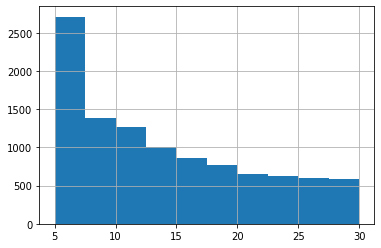

In [19]:
auto_waypoints['distance'].hist()

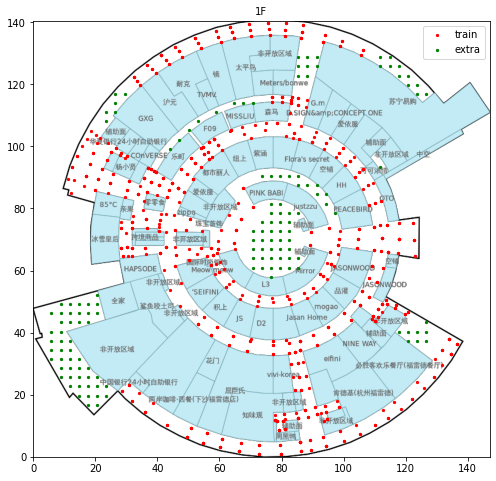

In [20]:
# sampleを可視化
ex_site = '5d2709d403f801723c32bd39'
ex_floor = '1F'
visualize_onemap(_train_waypoints, auto_waypoints, ex_site,ex_floor)

In [21]:
# N = 2  # 後処理の繰り返し回数
# for n in range(N):
#     if n == 0:
#         oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
#     else:
#         oofs_df = oofs_df.drop(['oof_x', 'oof_y', 'oof_min_x', 'oof_min_y'], axis=1).rename(columns={'oof_min_snap_x':'x', 'oof_min_snap_y':'y'})
#     oofs_df = post_processing_for_train(oofs_df, n, auto_waypoints)

In [22]:
# # waypoint補正前のx,yでの評価
# oof_score_post_process = mean_position_error(
#     oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
#     oofs_df['target_x'], oofs_df['target_y'], 0
#     )
# print(f"(after cost-min) CV:{oof_score_post_process}")

# # waypoint補正前のx,yでの評価
# oof_score_post_process = mean_position_error(
#     oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
#     oofs_df['target_x'], oofs_df['target_y'], 0
#     )
# print(f"(after cost-min + snap) CV:{oof_score_post_process}")

In [23]:
# oofs_df.to_csv("oof_pp.csv", index=False)

In [24]:
def post_processing_for_test(sub, n, auto_waypoints):

    sub_org = sub.copy()
    tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
    sub['site'] = tmp[0]
    sub['path'] = tmp[1]
    sub['timestamp'] = tmp[2].astype(float)

    ###############
    # cost min
    ###############
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    new_sub = pd.concat(dfs).sort_values('site_path_timestamp')

    ##############
    # snap to grid
    ##############
    train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')[['x', 'y', 'site', 'floor']]
    train_waypoints['is_train_grid'] = True 
    auto_waypoints['is_train_grid'] = False
    train_waypoints = pd.concat([train_waypoints, auto_waypoints[['x','y','site','floor', 'is_train_grid']]]).reset_index(drop=True)
    new_sub = sub_process(new_sub, train_waypoints)
    new_sub = add_xy(new_sub)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in new_sub.groupby(['site','floor']):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                            (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['x_'] = d['matched_point'].apply(lambda x: x[0])
        d['y_'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    new_sub2 = pd.concat(ds).sort_index()

    # Calculate the distances
    new_sub2['dist'] = np.sqrt((new_sub2['x']-new_sub2['x_'])**2 + (new_sub2['y']-new_sub2['y_'])**2)

    # add is_train_grid flag
    train_waypoints = train_waypoints.rename(columns={'x':'x_', 'y':'y_'})
    new_sub2 = new_sub2.merge(train_waypoints[['x_', 'y_', 'is_train_grid']].drop_duplicates(), on=['x_', 'y_'], how='left')
    new_sub2 = snap_to_grid(new_sub2)

    new_sub2 = new_sub2[['site_path_timestamp','floor','_x_','_y_']].sort_index()
    new_sub2 = new_sub2.rename(columns={'_x_':'x', '_y_':'y'})
    return new_sub2

In [25]:
N = 6
sub = sub.reset_index()
for n in range(N):
    sub = post_processing_for_test(sub, n, auto_waypoints)

626it [00:47, 13.21it/s]
626it [00:47, 13.08it/s]
626it [00:47, 13.05it/s]
626it [00:48, 13.00it/s]
626it [00:47, 13.07it/s]
626it [00:48, 12.93it/s]


In [26]:
sub.to_csv(EXP_NAME + '_cost_snap_sub.csv', index=False)

## sub確認

In [27]:
sub = pd.read_csv(EXP_NAME + '_cost_snap_sub.csv')
sub

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.360190,99.075780
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.450550
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,88.779945,108.933240
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.917800
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.574510,101.132225
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,201.819690,104.936270
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.825880,109.711815


In [28]:
compare_sub = pd.read_csv("../exp090/exp090_cost_snap_sub.csv")
_x = compare_sub["x"]
_y = compare_sub["y"]
x = sub["x"]
y = sub["y"]

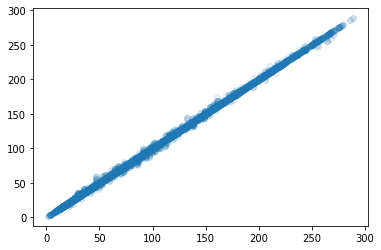

In [29]:
plt.scatter(x, _x, alpha=0.1)

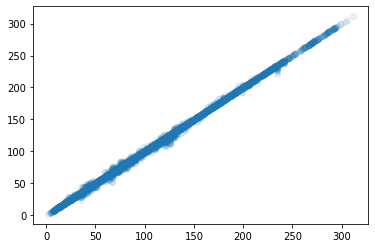

In [30]:
plt.scatter(y, _y, alpha=0.1)